In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import time
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats

from scipy import stats
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'axes.edgecolor':"0.3",
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'legend.fontsize':10,
  'font.size':fontsize,
  'font.family':'serif'}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path
import os

Using matplotlib backend: <object object at 0x000001543F30A490>


In [2]:
import sys
sys.path.append('../')

from metric_store import save_metrics, save_metric, load_metrics, get_metric_names, load_metric
from network_metrics import prepare_metric
from pipeline.pipeline import load_config

In [3]:
config_name = "pipeline.config"
config = load_config(config_name)

In [4]:
from corr_network import load_data, get_available_mask
data = load_data(config)
available_mask = get_available_mask(data)

In [45]:
metric_names = ['input_data/MSLP']
for metric_name in metric_names:
    config.metrics_plot_options['metric_name'] = metric_name
    metric = load_metric(config, metric_name)
    #metric = prepare_metric(metric_name, metric, available_mask)
    print(metric_name, metric.shape, config.metric_dimension[metric_name])    

input_data/MSLP (113960, 36, 69) 2D


In [6]:
prefix = 'network_metrics'
metric_names = list(get_metric_names(config, prefix = prefix).keys())
metric_names

['network_metrics/LCC',
 'network_metrics/GCC',
 'network_metrics/LCC_w',
 'network_metrics/GCC_w',
 'network_metrics/degree',
 'network_metrics/degree_w',
 'network_metrics/EVC',
 'network_metrics/EVC_w',
 'network_metrics/closeness',
 'network_metrics/closeness_w',
 'network_metrics/LCC_0.9',
 'network_metrics/GCC_0.9',
 'network_metrics/degree_0.9',
 'network_metrics/EVC_0.9',
 'network_metrics/closeness_0.9']

# Cyclone events

In [5]:
data = np.load('../cyclones_events.npz')
list(data.keys())
cyclone_events = data['cyclone_events_4']

In [6]:
cyclone_events = data['cyclone_events_2']

In [42]:
cyclone_events = data['cyclone_events_6']

In [8]:
cyclone_events.shape

(36, 69, 113960)

# Cyclone events 1D make

In [16]:
df_times = pd.read_csv(config.download_ERA5_options['work_dir'] / 'times.txt', header=None)
cyclone_events_1d = np.sum(cyclone_events, axis=(0, 1))
df = pd.DataFrame({
        'datetime': df_times[0],
        'cyclone_events_1d': cyclone_events_1d
    }
)
df.to_excel(config.download_ERA5_options['work_dir'] / 'cyclone_events_1d.xlsx')

In [15]:
df_times

,1982.01.01 00:00:00
0,1982.01.01 03:00:00
1,1982.01.01 06:00:00
2,1982.01.01 09:00:00
3,1982.01.01 12:00:00
4,1982.01.01 15:00:00
...,...
113954,2020.12.31 09:00:00
113955,2020.12.31 12:00:00
113956,2020.12.31 15:00:00
113957,2020.12.31 18:00:00


In [20]:
for i in range(100000):
    if np.sum(cyclone_events[:, :, i]) > 0:
        print(i)
        break

961


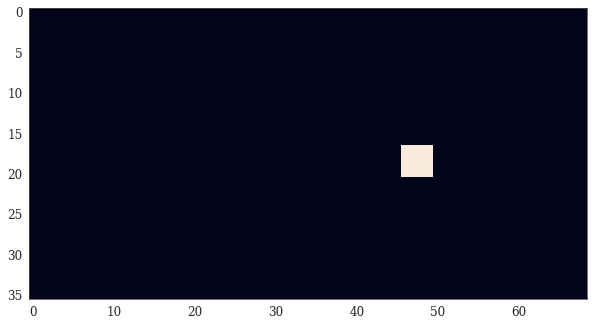

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(cyclone_events[:, :, 974])
plt.grid(0)

In [37]:
d = {'a': 1}

for d['a'] in [1, 2, 3]:
    print(d['a'])
d['a']    

1
2
3


3

In [46]:
from pathlib2 import Path

In [57]:
p = Path("a{config.g_test_options['track_size']}") / 'b'
str(p)
Path(str(p).format(**{"config.g_test_options['track_size']": 'xx'}))

KeyError: 'config'

In [6]:
import os
os.chdir('..')

In [7]:
from cyclone_metrics import get_cyclone_events
import numpy as np
#from cyclone_metrics import get_cyclone_events
from plot_network_metrics.utils import get_times_lats_lots
from cyclones_info.cyclones_info import get_cyclones_info, get_cyclones
from tqdm import tqdm

all_times, all_lats, all_lons = get_times_lats_lots(config)
cyclones_frame = get_cyclones_info(config)
cyclones_dict = get_cyclones(cyclones_frame, config.cyclone_metrics_options)

track_size = config.g_test_options['track_size']


In [4]:
import cyclones_info
#from cyclones_info import get_cyclone_for_special_number, extension_df_for_cyclone, full_extended_df_for_cyclone, get_cyclone_area
from datetime import datetime

def get_cyclone_area(cur_lat, cur_lon, lats, lons, track_size=2):
    indexes_lat = np.where(lats >= cur_lat)[0]  # lats sorted as >=
    indexes_lon = np.where(lons <= cur_lon)[0]

    message = ''

    if len(indexes_lat) == 0:
        ind_lat = 0
    else:
        ind_lat = indexes_lat[-1]

    if len(indexes_lon) == 0:
        ind_lon = 0
    else:
        ind_lon = indexes_lon[-1]

    if ((ind_lat == 0) or (ind_lat == len(lats)-1)) and (np.abs(cur_lat - lats[ind_lat]) > 0.75):
        message = 'Cyclone outside the grid'
    if ((ind_lon == 0) or (ind_lon == len(lons)-1)) and (np.abs(cur_lon - lons[ind_lon]) > 0.75):
        message = 'Cyclone outside the grid'

    # область = 4 клеток (2 по широте и 2 по долготе)
    window_half = (track_size - 2) // 2
    start_ind_lat = max(0, ind_lat - window_half)
    end_ind_lat = min(ind_lat + 2 + window_half, len(lats))
    start_ind_lon = max(0, ind_lon - window_half)
    end_ind_lon = min(ind_lon + 2 + window_half, len(lons))

    return message, start_ind_lat, end_ind_lat, start_ind_lon, end_ind_lon

def get_cyclone_events(cyclones_frame, cyclones_dict, times, lats, lons, track_size=2, need_shift=False, shift_lo=20 * 8, shift_hi=50 * 8):
    shapes = (len(lats), len(lons), len(times))
    cyclones_events = np.zeros(shapes, dtype='bool')
    from tqdm import tqdm

    for cyclone in tqdm(cyclones_dict):
        curr_cyc_df = cyclones_info.get_cyclone_for_special_number(cyclones_frame, cyclone['number'])
        # дополняем циклон точками каждые три часа (если в таблице нет данных за какое-то время,
        # то берём lon lat как в предыдущей известной временной точке)
        
        curr_cyc_df = cyclones_info.extension_df_for_cyclone(curr_cyc_df)
        
        curr_cyc_df = cyclones_info.full_extended_df_for_cyclone(curr_cyc_df)
        
        if need_shift:
            shift = np.random.randint(shift_lo, shift_hi)
        else:
            shift = 0
        if not curr_cyc_df.empty:
            for k in range(len(curr_cyc_df)):
                d = datetime.strptime(curr_cyc_df['Date (DD/MM/YYYY)'][k] + ' ' + curr_cyc_df['Time (UTC)'][k],
                                      '%d/%m/%Y %H%M')
                ind_time = np.searchsorted(times, d.strftime('%Y.%m.%d %H:%M:%S'))
                #ind_time = 0
                ind_time = (ind_time + shift) % shapes[2]
                message, start_ind_lat, end_ind_lat, \
                start_ind_lon, end_ind_lon = get_cyclone_area(float(curr_cyc_df['Latitude (lat.)'][k]),
                                                              float(curr_cyc_df['Longitude (lon.)'][k]),
                                                              lats, lons, track_size)
                if message == '':
                    cyclones_events[start_ind_lat:end_ind_lat, start_ind_lon:end_ind_lon, ind_time] = True

    return cyclones_events

In [19]:
cyclones_events = get_cyclone_events(cyclones_frame, cyclones_dict, all_times, all_lats, all_lons, track_size, need_shift=True)


100%|██████████| 362/362 [00:31<00:00, 11.65it/s]


In [14]:
np.searchsorted(all_times, '1992.01.01 04:00:00')

29218

# Check metric shapes

In [21]:
tmp_dir = Path(r'D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics')
import glob
file_names = glob.glob(str(tmp_dir) + '\*')
for file_name in file_names:
    data = np.load(file_name)
    print(data.shape, file_name)

(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\closeness_0.9.npy
(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\closeness_0.95.npy
(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\closeness_w.npy
(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\degree_0.9.npy
(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\degree_0.95.npy
(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\degree_w.npy
(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\EVC_0.9.npy
(36, 69, 2920) D:\PC\UNN\Science\Climate\data\ERA5\tmp\probability_for_metrics\diff_metrics\network_metrics\EVC_0.95.npy
(36, 69, 2920)

In [7]:
file_names

['D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\closeness_0.9.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\closeness_0.95.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\closeness_w.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\degree_0.9.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\degree_0.95.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\degree_w.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\EVC_0.9.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\EVC_0.95.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\EVC_w.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\GCC_0.9.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\GCC_0.95.npy',
 'D:\\PC\\UNN\\Science\\Climate\\data\\ERA5\\tmp\\network_metrics\\GCC_w.npy',
 'D:\

# Cut 2018 year only from cyclone_events.npz

In [26]:
tmp_dir = Path(r'D:\PC\UNN\Science\Climate\data\ERA5\tmp')
cyclones_events = np.load(tmp_dir / 'cyclones_events.npz')
list(cyclones_events.keys())

['cyclone_events_2',
 'cyclone_events_4',
 'cyclone_events_6',
 'cyclone_events_8',
 'cyclone_events_10',
 'cyclone_events_12']

In [30]:
times = pd.read_csv(tmp_dir / 'times.txt', header=None)
times_full = pd.read_csv(tmp_dir / 'times_full.txt', header=None)

In [46]:
pos = times_full[0].tolist().index(times[0].tolist()[0])
start = pos
finish = pos + len(times)

In [48]:
cyclones_events_small = {}
for name in cyclones_events:
    cur = cyclones_events[name]
    cur = cur[:, :, start:finish]
    cyclones_events_small[name] = cur

In [49]:
np.savez_compressed(tmp_dir / 'cyclones_events_small.npz', **cyclones_events_small)

In [7]:
from plot_network_metrics.utils import get_times_lats_lots
from cyclones_info.cyclones_info import get_cyclones_info, get_cyclones

all_times, all_lats, all_lons = get_times_lats_lots(config)
#cyclones_frame = get_cyclones_info(config)
#cyclones_dict = get_cyclones(cyclones_frame, config.cyclone_metrics_options)

In [16]:
from plot_network_metrics.utils import get_sond_times
len(get_sond_times(config, all_times))


38064

In [14]:
all_times[0][5:7]

'01'

In [18]:
available_mask.sum()

1319

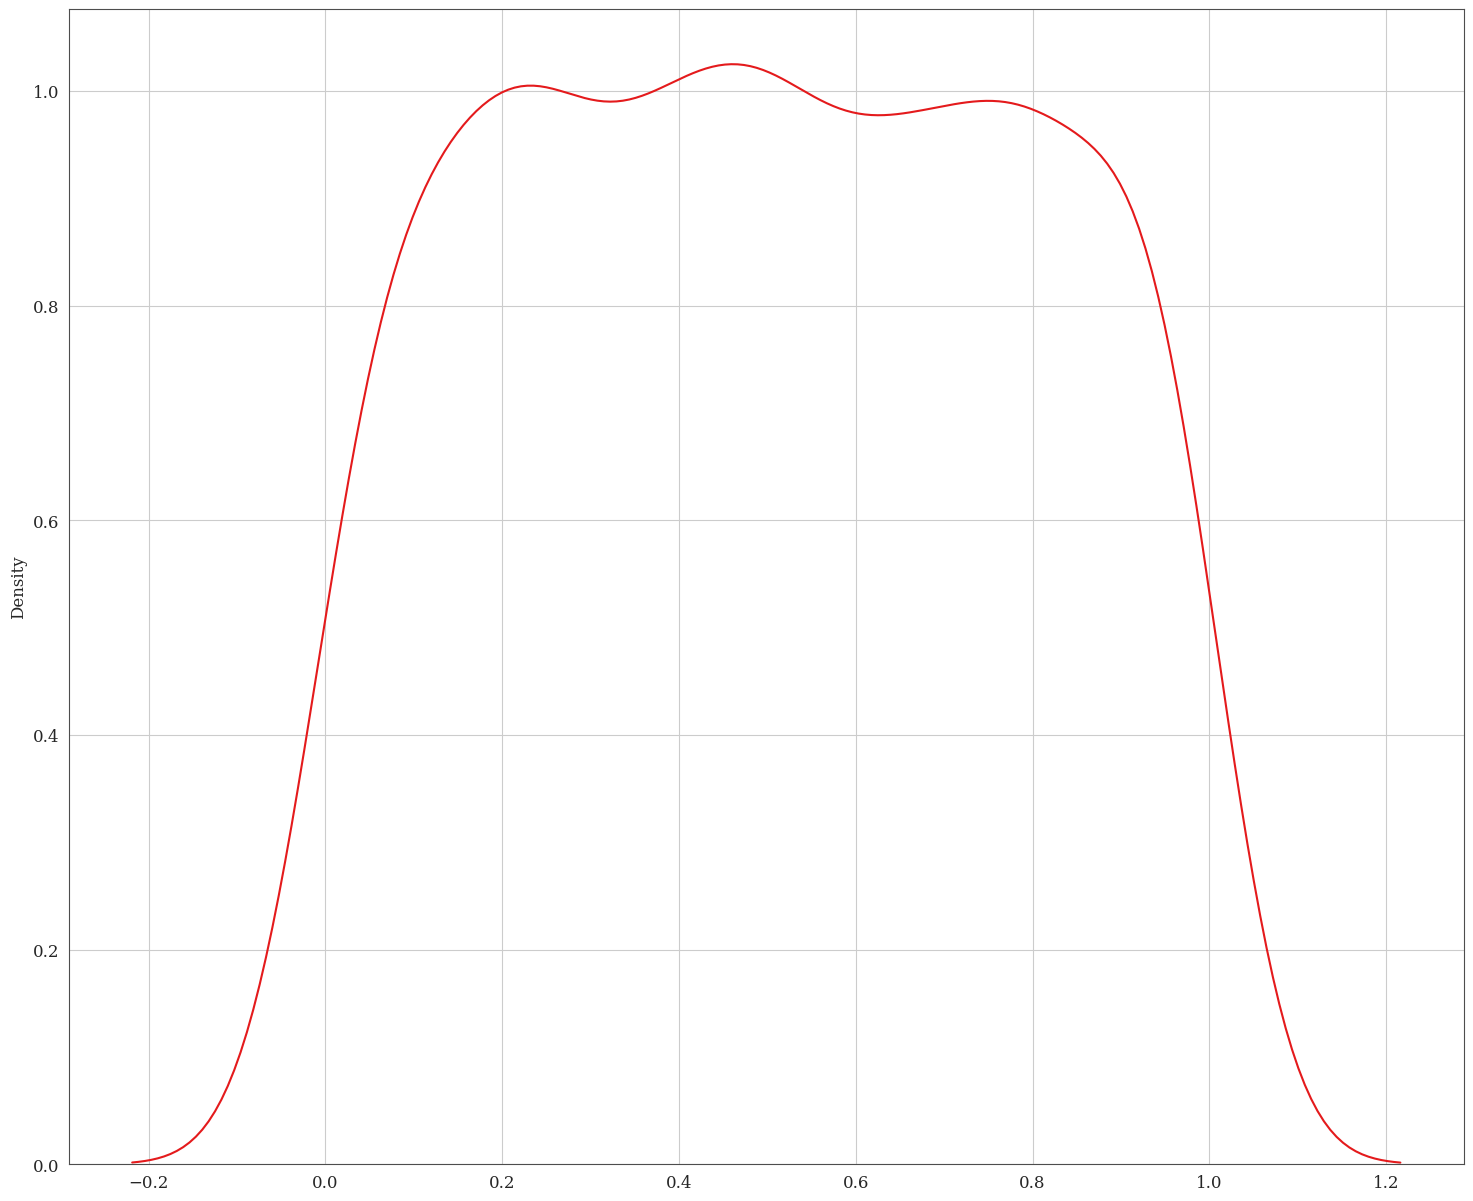

In [21]:
res = sns.kdeplot(np.random.rand(1000));

In [5]:
config.cyclones_info['cyclones_file_name'] = '../' + config.cyclones_info['cyclones_file_name']

In [14]:
from cyclones_info.cyclones_info import filter_cyclones_by_time
from plot_network_metrics.utils import get_times_lats_lots
from cyclones_info.cyclones_info import get_cyclones_info, get_cyclones
from plot_network_metrics.utils import get_sond_times
all_times, all_lats, all_lons = get_times_lats_lots(config)
cyclones_frame = get_cyclones_info(config)
cyclones_dict = get_cyclones(cyclones_frame, config.cyclone_metrics_options)

sond_time_inds = get_sond_times(config, all_times)
sond_times = all_times[sond_time_inds]
cyclones_dict_sond = filter_cyclones_by_time(cyclones_dict, sond_times)

In [15]:
len(sond_time_inds)

38064

In [17]:
len(cyclones_dict_sond)

197

In [20]:
cyclones_dict_sond[0]

{'start': '1982.09.09 03:00:00',
 'end': '1982.09.10 12:00:00',
 'number': '11_1982',
 'name': ''}